# Convolutional Neural Networks (CNNs)

We want to process data (i.e. images) where the relative position of objects is relevant- we want the model to understand translational invariance, and also be able to discern features shared by neighbouring regions of the data (hard edges from dark/light contrast in the pixels, etc.)

If we are looking at an image of a plane in the sky, we are more interested in the local pixels that make up the plane rather than features or objects at a large distance- thus, we want pixels far from the plane to be "weighted" much less somehow than the pixels within the plane and up to its edges. One way of doing this would be to have a <b>weight matrix with many entries set to zero</b>. But there is a better approach.

# Convolution

Basically, we perform piecewise multiplication over the image tensor using a smaller tensor- or <b>kernel</b>. A typical size for a small kernel tensor would be $3 \times 3$. 

The operation of convolution essentially achieves what we would have by having weights equal to $0$ outside of the immediate region of the pixels.

The weights inside of the kernel are not known at the beginning, but instead are parameters to be optimized during training. 

In [1]:
import torch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(123)

In [2]:
#Class names
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7'

#Initialise the training set
cifar10 = datasets.CIFAR10(
    root=data_path,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(), #convert the images to tensors
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)) #normalise RGB values to have mean at 0 and with unit standard deviation
    ])
)

#Initialise the validation set
cifar10_val = datasets.CIFAR10(
    root=data_path,
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(), #convert the images to tensors
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)) #normalise RGB values to have mean at 0 and with unit standard deviation
    ])
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
label_map = {0:0, 2:1} #map airplane to 0th index in cifar 2, map bird to index 1

#Extract the plane and bird images from cifar10 to create training and validation sets
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label == 0 or label == 2]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label == 0 or label == 2]

In [5]:
#Our new sequential model!

connected_model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

#Combination of the logsoftmax output and the NLL loss function
loss_fn = nn.CrossEntropyLoss()

In [6]:
#Make a list of all of the model's modifiable parameters
numel_list = [p.numel() for p in connected_model.parameters() if p.requires_grad == True]
numel_list, sum(numel_list)

([3145728, 1024, 524288, 512, 65536, 128, 256, 2], 3737474)

In [7]:
conv = nn.Conv2d(3, 16, kernel_size=3)

#Weight matrix is 16x3x3x3- outputs a 2d image with 3 colour channels to a 16-dimensional vector
#This necessarily makes the bias vector have dimension 16
conv, conv.weight.shape, conv.bias.shape

(Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1)),
 torch.Size([16, 3, 3, 3]),
 torch.Size([16]))

In [8]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) #add extra dimension that indicates BATCH number
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

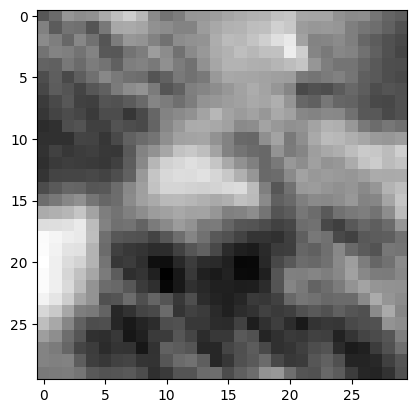

In [9]:
plt.imshow(output[0, 0].detach(), cmap='gray') #Select the image from batch 0, weight 0
plt.show() #produces 30x30 image

### Where did the other pixels go?
The kernel slides around the image from left to right, producing $$(\text{width}-\text{kernel size} + 1)$$ horizontal and vertical positions positions. Here, $32 - 3 + 1 = 30$, hence the resulting $30 \times 30$ dimensions.

We can add <b>padding</b> in order to introduce fictitious $0$ pixels around the border of the image in order to preserve the original dimensions.

In [10]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)

output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape #Now the dimensions should match, as we've added a border of 0 pixels around the edge of the img matrix.

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

In [11]:
#Set the initial kernel parameters by hand 

#With 0 bias, and with the weights all set to 1/9, we expect the convolution to simply blur the image.
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0 / 9.0)

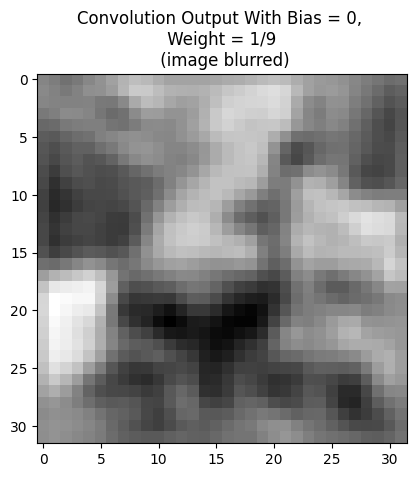

In [12]:
output = conv(img.unsqueeze(0))

plt.imshow(output[0, 0].detach(), cmap='gray')
plt.title('Convolution Output With Bias = 0, \n Weight = 1/9 \n (image blurred)')
plt.show()

### Edge-Detection Kernel
We now use a kernel of the following form:

$$ \begin{bmatrix}
-1.0 & 0.0 & 1.0 \\
-1.0 & 0.0 & 1.0 \\
-1.0 & 0.0 & 1.0 
\end{bmatrix}  $$

which will return a <b>feature map</b> with large values when neighbouring pixels exhibit high contrast in their intensity (i.e. are at the edges of the image).

In [13]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) #Three input channels, RGB, and one output (gray value)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0, 1.0], 
                                   [-1.0, 0, 1.0], 
                                   [-1.0, 0, 1.0]])
    conv.bias.zero_()

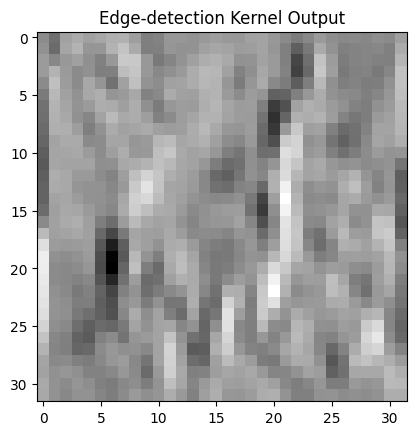

In [14]:
output = conv(img.unsqueeze(0))

plt.imshow(output[0,0].detach(), cmap='gray')
plt.title('Edge-detection Kernel Output')
plt.savefig('edge_detection.png')
plt.show()


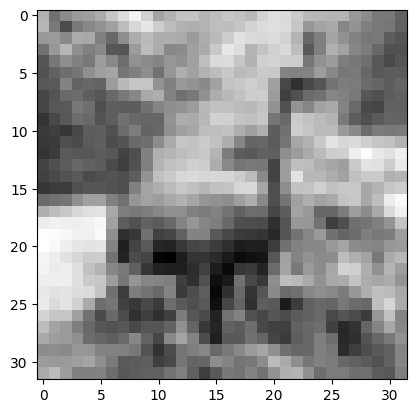

In [15]:
plt.imshow(img.mean(0), cmap='gray')
plt.savefig('blurry_bird.png')

## Downsampling
We want our neural network to realise that adjacent pixels are correlated (e.g. are able to identify wings). But the finite kernel size will limit the area over which our model takes correlation into account. If we use <b>too large</b> a kernel, then we return to the previous problem where we lose translational invariance- for example, if we use a kernel with dimensions equal to that of the image. So we introduce <b>downsampling</b>.

Scaling down the image by half is equal to reducing the pixel number by a factor of $2 \times 2 = 4$. So, for an input of 4 pixels, we want a single pixel as an output.

#### Downsampling Methods
<ul>
<li><b>Averaging</b> over the four pixels;</li>
<li>Taking the max value of the four pixels (<b>max pooling</b>)- note that stride is set to the kernel dimensions;</li>
<li><b>Strided convolution</b>.</li>
</ul>

In [16]:
pool = nn.MaxPool2d(2) #max pooling using a kernel size of 2x2- i.e. takes 4 pixels and returns 1
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape #expecting to reduce image dimensions by half

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

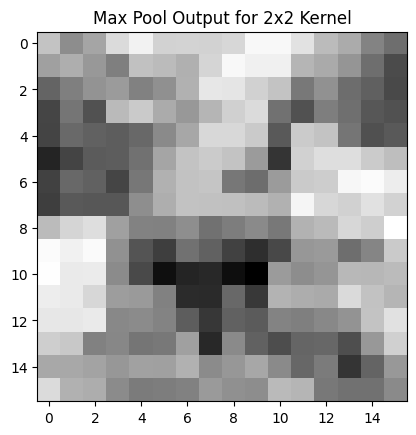

In [17]:
plt.imshow(output[0,0].detach(), cmap='gray')
plt.title('Max Pool Output for 2x2 Kernel')
plt.show()

## Revised Network
Now, with max-pooling in play, we have a final revised network. In summary, we want:

A <b>first hidden layer</b>, taking $3$ input channels (RGB) and from that giving us 16 input features. Hopefully this is enough to distinguish between the two classes of image. So the weight matrix, $W$, will have dimensions $16 \times 3 \times (3 \times 3)$. The $16$ dimension comes from the number of features- <b>this is the number of "filters"</b>. For each of the $3$ colour channels, we have a $3 \times 3$ kernel matrix. The output of this layer is a tensor of dimensions $16 \times 32 \times 32$ (we have replaced the first dimension, length $3$, with one of length $16$, and the convolution is used with padding). We then use a <b>tanh activation function</b>.

A <b>second hidden layer</b>, which uses <b>max-pooling</b>, with <b>padding set to 1</b>, generating a <i>feature map</i> of the first layer output, reducing the image dimensions to $16 \times 16$, and then takes <b>another convolution</b> of this feature map. We then use a <b>tanh activation function</b>.

A <b>third hidden layer</b>, which does another round of max-pooling. Now, the images are down to an $8 \times 8$ feature map.

In short:
<ul>
<li>Max-pooling reduces the dimensions by a factor of 2, producing increasingly small feature maps.</li>
<li>Convolution keeps track of the relationships between adjacent pixels in each feature map. The use of padding set to 1 preserves the dimensions of each of these feature maps.</li>
</ul>

In [18]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1), #Maps 3 colour channels to 16 features
    nn.Tanh(),
    nn.MaxPool2d(2), #max-pooling using 2x2 kernel, which reduces the map's dimensions by factor of 2
    nn.Conv2d(16, 8, kernel_size=3, padding = 1), #downsample to 16 feature maps.
    nn.Tanh(),
    nn.MaxPool2d(2), #Now we have 8 features, and each feature has an activation map of dimensions 8x8- 8x8x8 output
    
    #Need to here flatten the 8x8x8 tensor into a vector of length 8*8*8= 512- but where is the output??

    #First fully-connected layer
    nn.Linear(8*8*8, 32), #turn into one vector of length 32
    nn.Tanh(),
    nn.Linear(32, 2) #Output a 2-dimensional vector encoding probability of being a bird/plane
)

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

#### Subclassing
How do we get the output of different layers in the network while it is live? We need to do so in order to, for example, flatten the tensor that we get out of the second MaxPool in the above network, but at the moment we can't just call the output of each layer before running each net. That's where the <code>nn.Module</code> comes into play.

In [19]:
#New paradigm: have all the layers as functions of the class, and then call them in the "forward" function

class Net(nn.Module):
    def __init__(self):
        super().__init__() #call the init method of the parent class
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding = 1) 
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        #unsqueeze into 512-long tensor
        self.fc1 = nn.Linear(512, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2) #fc = fully-connected

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 512) #give us 512 columns and some unknown number of columns
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out
            

In [20]:
torch.manual_seed(123)
model = Net()

out = model.forward(img.unsqueeze(0))

out

tensor([[0.0908, 0.0938]], grad_fn=<AddmmBackward0>)

In [21]:
#Using the nn.functional module
#New paradigm: have all the layers as functions of the class, and then call them in the "forward" function

class Net(nn.Module):
    def __init__(self):
        super().__init__() #call the init method of the parent class
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding = 1) 
        #unsqueeze into 512-long tensor
        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(32, 2) #fc = fully-connected

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 512) #give us 512 columns and some unknown number of columns
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
            

In [22]:
torch.manual_seed(123)
model = Net()

out = model(img.unsqueeze(0))

out

tensor([[0.0908, 0.0938]], grad_fn=<AddmmBackward0>)

In [23]:
def training_loop(n_epochs:int, optimizer:optim.Optimizer, loss_fn, train_loader):
    for _ in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if _ == 1 or _ % 10 == 0:
            print(f'Epoch: {_}, Average loss in batch: {loss_train/len(train_loader)}')

In [24]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

# training_loop(
#     n_epochs=100,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     train_loader=train_loader
# )

Epoch: 1, Average loss in batch:0.5606662872110962
Epoch: 10, Average loss in batch:0.33586478584511265
Epoch: 20, Average loss in batch:0.29890418669600394
Epoch: 30, Average loss in batch:0.27424065393816893
Epoch: 40, Average loss in batch:0.24808122991186798
Epoch: 50, Average loss in batch:0.22801073512453943
Epoch: 60, Average loss in batch:0.20554896837966458
Epoch: 70, Average loss in batch:0.19003457542817304
Epoch: 80, Average loss in batch:0.17482441924749667
Epoch: 90, Average loss in batch:0.16061825253021944
Epoch: 100, Average loss in batch:0.14880908892792502


In [31]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False) 
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False) 

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) #gives us index and predicted value for that index
                total += imgs.shape[0]
                correct += int((predicted==labels).sum())
    
        print(f"Accuracy {name}: {correct/total:.2f}")

In [32]:
validate(model=model, train_loader=train_loader, val_loader=val_loader)

Accuracy train: 0.95
Accuracy val: 0.89


In [27]:
#save the model
#torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [28]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

/var/folders/j5/qqf885v16ps2h__10kf0m2th0000gn/T/ipykernel_73610/398628253.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(data_p

<All keys matched successfully>

### Regularisation
Regularisation penalises large values of the weights. L2 is the sum of the squares, L1 is the sum of the absolute magnitudes.

In [38]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [34]:
#L2 normalisation loop

def training_loop(n_epochs:int, optimizer:optim.Optimizer, loss_fn, train_loader):
    for _ in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            #Include L2 normalisation by penalising the sum of the squares of the weights.
            l2_lambda = 0.001 #hyperparameter- WEIGHT DECAY
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if _ == 1 or _ % 10 == 0:
            print(f'Epoch: {_}, Average loss in batch:{loss_train/len(train_loader)}')

In [39]:
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader
)

Epoch: 1, Average loss in batch:0.6007977071081757
Epoch: 10, Average loss in batch:0.3564192237937526
Epoch: 20, Average loss in batch:0.3215361787065579
Epoch: 30, Average loss in batch:0.2987819999266582
Epoch: 40, Average loss in batch:0.27975337976103376
Epoch: 50, Average loss in batch:0.26426563046540424
Epoch: 60, Average loss in batch:0.2513378332754609
Epoch: 70, Average loss in batch:0.24031758170788456
Epoch: 80, Average loss in batch:0.23060923824264745
Epoch: 90, Average loss in batch:0.22179390651405237
Epoch: 100, Average loss in batch:0.21341491063499146


## Implementing Dropout

In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
